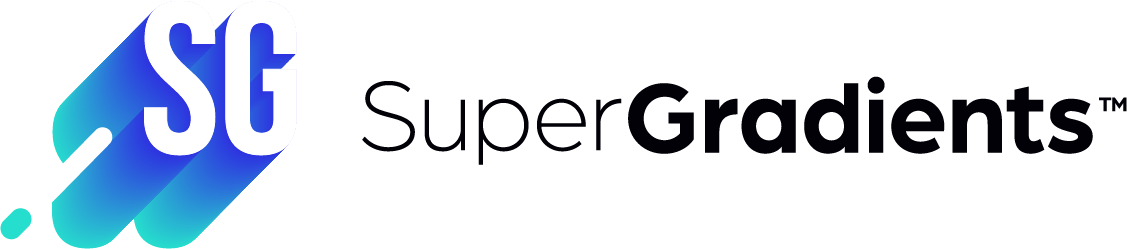

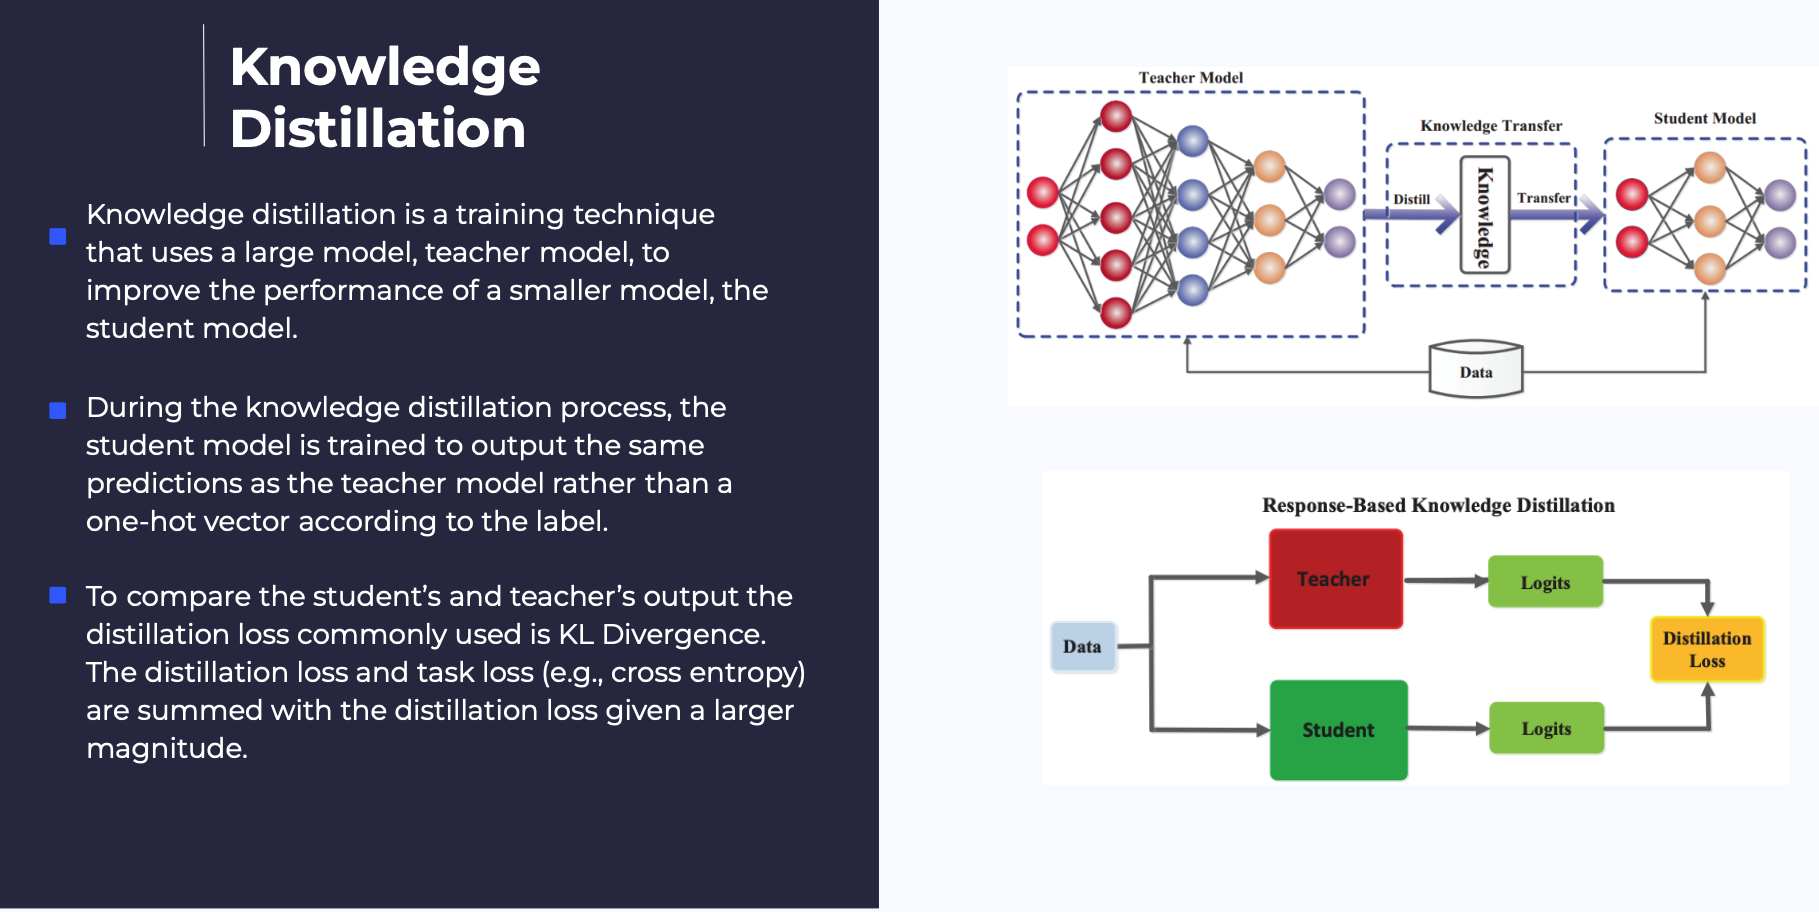

In [3]:
!pip install -qq super_gradients==3.3.1

# Knowledge Distillation Training with SuperGradients

This short quickstart tutorial uses SuperGradients to demonstrate knowledge distillation training, and includes:

1. Testing pretrained BEiT model
2. Introdocing new KD supportive objects
3. KD Training and Testing
4. Predict with the student

# 1. Testing pretrained BEiT model

The logic here is similar to any testing scenario in super-gradients.
- We initialize a `Trainer` object, which is in charge of everything that happens during training- saving checkpoints, plotting etc.
The experiment name argument will cause the checkpoints, logs and tensorboards to be saved in a directory with the same name under the checkpoints
directory. get both the model and the test dataloader, and finally we run the test.
- We get our Cifar10 `DataLoader`. Note that here we override the default dataset transforms, because BEiT expects images of size (224x224) which is not the case of cifar10 (32x32).
- We load our BEiT `nn.Module` pretrained on Cifar10. The size is as we
- We evaluate the model on `Accuracy` and `Top5` metrics.

In [4]:
import os
from super_gradients.training import Trainer, models, dataloaders
from super_gradients.training.metrics import Accuracy, Top5
from torchvision import transforms

checkpoint_dir = os.path.abspath("notebook_ckpts")
trainer = Trainer(experiment_name="beit_base_patch16_224_test", ckpt_root_dir=checkpoint_dir)
test_dataloader = dataloaders.get("cifar10_val", dataloader_params={"batch_size": 64, "num_workers": 2}, dataset_params={"transforms": [transforms.ToTensor(), transforms.Resize(224)]})
pretrained_beit = models.get('beit_base_patch16_224', arch_params={'num_classes': 10, "image_size": [224, 224], "patch_size": [16, 16]}, pretrained_weights="cifar10")
metrics = trainer.test(model=pretrained_beit, test_loader=test_dataloader, test_metrics_list=[Accuracy(), Top5()])
print()
print(f"Accuracy: {metrics['Accuracy']:.3f}")
print(f"Top 5:    {metrics['Top5']:.3f}")

Testing: 100%|██████████| 157/157 [00:41<00:00, 12.08it/s]

Now that we have loaded our pretrained model and that we made sure that it has the expected accuracy, we can use it for knowledge distillation.

# 2. Introdocing new KD supportive objects:

Equivalently to the `Trainer` that is designed for the training/testing a single model, the `KDTrainer` was designed to train/test a student model with help of a teacher model.


In [5]:
import os
from super_gradients.training import KDTrainer

experiment_name = "kd_cifar10_resnet"

kd_trainer = KDTrainer(experiment_name=experiment_name, ckpt_root_dir=checkpoint_dir)

As before, we instantiate train and validation `DataLoader` designed that we will use during training, along with a Resnet18 `nn.module` that will be our student network.

In [6]:
from super_gradients.training import dataloaders, models


train_dataloader = dataloaders.get("cifar10_train", dataloader_params={"batch_size": 128, "num_workers": 2})
val_dataloader = dataloaders.get("cifar10_val", dataloader_params={"batch_size": 512, "num_workers": 2})

student_resnet18 = models.get('resnet18_cifar', num_classes=10)

Testing: 100%|██████████| 157/157 [00:42<00:00,  3.73it/s]


Let's visualize what we've got there.

We have images and labels, with the default batch size of 256 for training.

In [7]:
from matplotlib import pyplot as plt

def show(images, labels, classes, rows=6, columns=5):
  fig = plt.figure(figsize=(10, 10))

  for i in range(1, columns * rows + 1):
      fig.add_subplot(rows, columns, i)
      plt.imshow(images[i-1].permute(1, 2, 0).clamp(0, 1))
      plt.xticks([])
      plt.yticks([])
      plt.title(f"{classes[labels[i-1]]}")

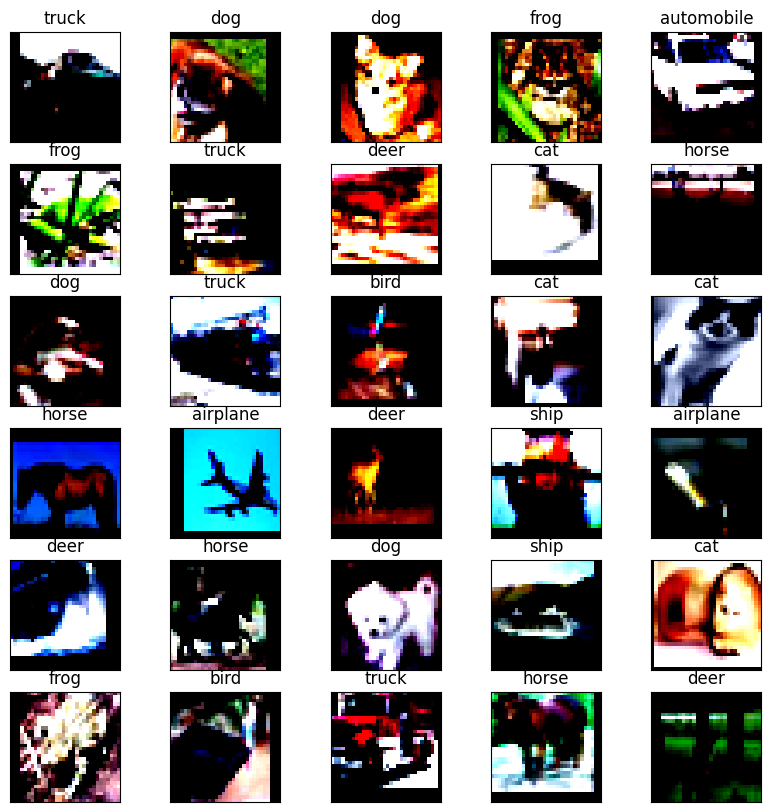

In [8]:
vis_images_train, vis_labels_train = next(iter(train_dataloader))
show(vis_images_train, vis_labels_train, classes=train_dataloader.dataset.classes)

print(vis_images_train.shape, vis_labels_train.shape)

**Defining Training Hyperparameters**

Most of the below arguement's use has already been demonstarted in previous tutorials. We will use the training hyperparameters that we defined for resnet models on imagenet dataset, and only overwrite the loss and the number of epoch to train on.

Do notice the `KDLogitsLoss` we use as our loss function- which mathematically is the weighted sum of:


(1- distillation_loss_coeff) * CrossEntropyLoss (applied on the "regular" dataset labels)  + KLDivergenceLoss (applied on the teacher's raw outputs).



In [9]:
from super_gradients.training import training_hyperparams
from super_gradients.training.losses import KDLogitsLoss, CrossEntropyLoss


kd_params = {
    "max_epochs": 3,          # We will stop after 3 epochs because it is slow to train on google collab
    'lr_cooldown_epochs': 0,  # We don't want to use lr cooldown since we only train for 3 epochs
    'lr_warmup_epochs': 0,    # We don't want to use lr  warmup  since we only train for 3 epochs
    "loss": KDLogitsLoss(distillation_loss_coeff=0.8, task_loss_fn=CrossEntropyLoss()),
    "loss_logging_items_names": ["Loss", "Task Loss", "Distillation Loss"]}

training_params = training_hyperparams.get("imagenet_resnet50_kd", overriding_params=kd_params)

You can see all the training hyperparamters that 'training_params' includes.

In [10]:
from pprint import pprint

pprint(training_params)

Additionally, note that our teacher model expects input of size 224X224 while we wish to train our student on 32X32 images.

Because our student and our teacher expect different input size we cannot find an output size of the dataset that would satisfy both. To handle this situation, the `KDTrainer` accepts an extra architecture parameter called "teacher_input_adapter" and that consists of a `transforms`. That way the teacher will not directly receive the output of the dataset but instead a transformed version of it, with expected size.

In [11]:
arch_params={"teacher_input_adapter": transforms.Resize(224)}

# 3. KD Training and Testing

Launching the tensoboard process:

In [12]:
%load_ext tensorboard
%tensorboard --logdir notebook_ckpts --bind_all

Launching TensorBoard...

Finally, call train:

In [13]:
kd_trainer.train(training_params=training_params,
                 student=student_resnet18,
                 teacher=pretrained_beit,
                 kd_architecture="kd_module",
                 kd_arch_params=arch_params,
                 train_loader=train_dataloader, valid_loader=val_dataloader)

Validating epoch 3: 100%|██████████| 20/20 [00:37<00:00,  1.72it/s]

In [14]:
from super_gradients.training.metrics import Accuracy, Top5

metrics = trainer.test(model=student_resnet18, test_loader=val_dataloader, test_metrics_list=[Accuracy(), Top5()])
print()
print(f"Accuracy: {metrics['Accuracy']:.3f}")
print(f"Top 5:    {metrics['Top5']:.3f}")

Testing:  95%|█████████▌| 19/20 [00:25<00:00,  2.79it/s]

# 4. Predict with the student
As the training was complete you can use the trained model to predict on your data

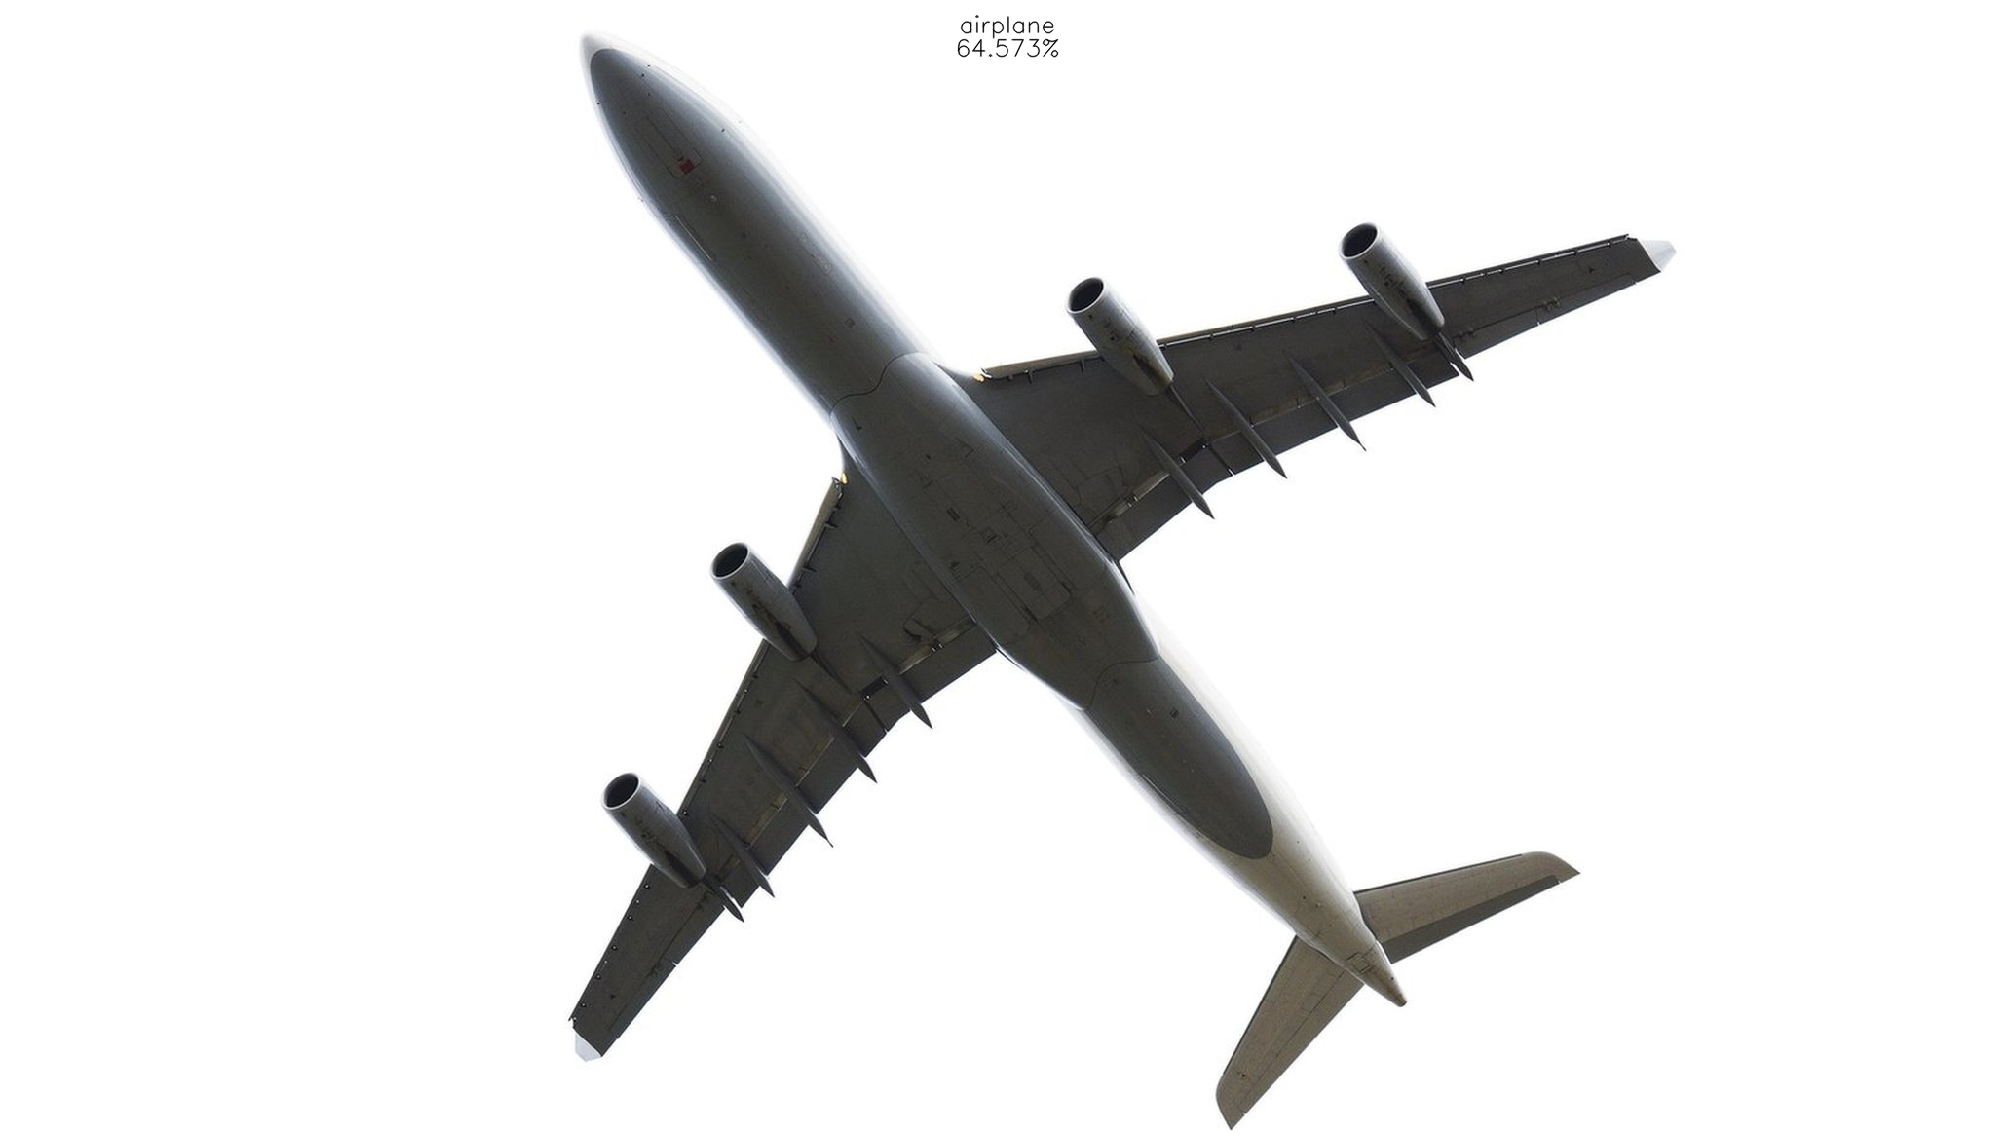

In [19]:
# We load the model as we would in a real worl situation, but we could also directly "student_resnet18"
trained_model = models.get('resnet18_cifar', checkpoint_path=f"{kd_trainer.checkpoints_dir_path}/ckpt_best.pth", num_classes=10)

url = "https://c.files.bbci.co.uk/B52F/production/_121138364_mediaitem121137729.jpg"
trained_model.predict(url).show()

Once training is finished, you can use the student model. All of the [architectures](https://deci-ai.github.io/super-gradients/user_guide.html#network-architectures) offered by SuperGradients compilation processes have been verified and can be uploaded to [Deci Lab](https://docs.deci.ai/docs/quickstart) for runtime optimization (including quantization and graph compilers) and benchmarking on various hardwares.  <!--Be sure to see how one can do so in our deci_platform integration tutorial <link>. -->